In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
import os
#改变当前工作目录到谷歌云盘的路径
path="/content/drive/MyDrive/Colab Notebooks/project_data/project/"
os.chdir(path)
os.listdir(path)
#使用wget命令下载数据集到这个路径
#!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/data.csv

['.DS_Store',
 'X_train_valid.npy',
 'person_train_valid.npy',
 'y_test.npy',
 'X_test.npy',
 'person_test.npy',
 'y_train_valid.npy',
 'EEG_loading.ipynb',
 'model_WGAN-GP.py',
 'plt_cnn_results.py',
 'model_WGAN.py',
 'load_data.py',
 'model_DCGAN.py',
 'data_preprocessing.py',
 'best_model.h5',
 'EEG_loading-Copy1.ipynb',
 '__pycache__',
 '.ipynb_checkpoints',
 'logs',
 'Copy of best_model.h5',
 'saved_model.pb',
 'BestModel',
 'BestModel_withoutfilter',
 'CNN_confusionmatrix.png']

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf                  # TensorFlow
import tensorflow.nn as nn               # nn contains useful neural network functions like softmax, relu, tanh
from tensorflow import keras             # high level API for TensorFlow
import tensorflow.keras.layers as layers # contains layers like RNN, CNN, LSTM
from tensorflow.keras.layers import Permute, Bidirectional, BatchNormalization, Conv2D, Dense, Dropout,LeakyReLU, ELU, Flatten, AveragePooling2D, MaxPool2D, TimeDistributed, GRU
from tensorflow.keras.regularizers import L1L2
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Permute, Bidirectional, BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, TimeDistributed, GRU
from tensorflow.keras.regularizers import L1L2
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Permute, Bidirectional, BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, TimeDistributed, GRU
from tensorflow.keras.regularizers import L1L2
from tensorflow.python.client import device_lib

In [11]:
import numpy as np
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


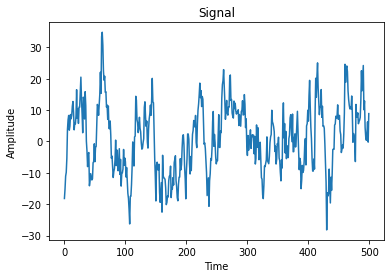

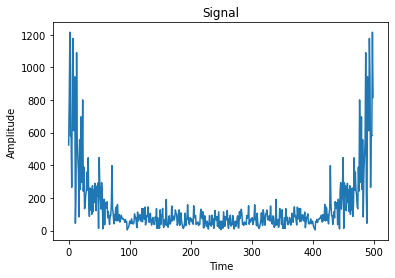

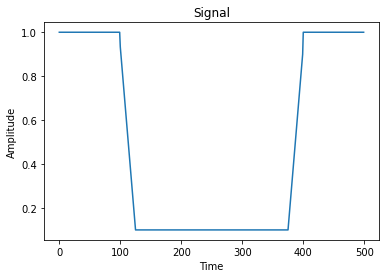

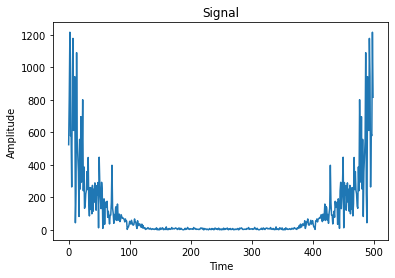

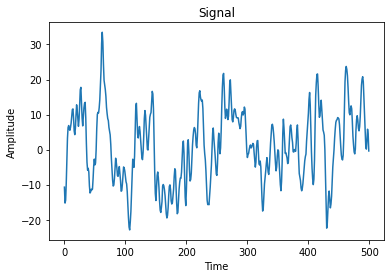

In [12]:
def data_crop(X):
    return X[:,:,0:500]

def data_augmentation(x):
    filter_x = np.zeros(x.shape)
    filter_low_pass = np.zeros(x.shape[2])
    for ii in range(500):
        if ii < 100:
            filter_low_pass[ii] = 1
        if ii >= 100 and ii < 125:
            filter_low_pass[ii] = (125 - ii)/30+0.1
        if ii >= 125 and ii < 375:
            filter_low_pass[ii] = 0.1
        if ii >= 375 and ii < 400:
            filter_low_pass[ii] = (-375 + ii)/30+0.1
        if ii >= 400 and ii < 500:           
            filter_low_pass[ii] = 1
    
    for ii in range(x.shape[0]):
        for jj in range(x.shape[1]):
            temp_x = x[ii,jj,:]
            fft_x = np.fft.fft(temp_x)
            fft_x_filter = fft_x*filter_low_pass
            filter_x[ii,jj,:] = np.real(np.fft.ifft(fft_x_filter))
    return filter_x
    
def data_augmentation_1(x,y):
    
    # block is defined to find the size of the block to apply average and max pooling 
    
    x_noise = x + np.random.normal(0.0, 0.5, x[:,:].shape)
    
    total_x = np.vstack((x, x_noise))
    total_y = np.vstack((y, y))
    print('the size of the total x:',total_x.shape)
    print('the size of the total y:',total_y.shape)
    
    
    return total_x,total_y

test_x = X_train_valid[2,10,0:500]

fig, axs = plt.subplots()
axs.set_title("Signal")
axs.plot(range(500), test_x, color='C0')
axs.set_xlabel("Time")
axs.set_ylabel("Amplitude")
plt.show()

fft_test_x = np.fft.fft(test_x)

fig, axs = plt.subplots()
axs.set_title("Signal")
axs.plot(range(500), np.abs(fft_test_x), color='C0')
axs.set_xlabel("Time")
axs.set_ylabel("Amplitude")
plt.show()

filter_low_pass = np.zeros(500)
for ii in range(500):
    if ii < 100:
        filter_low_pass[ii] = 1
    if ii >= 100 and ii < 125:
        filter_low_pass[ii] = (125 - ii)/30+0.1
    if ii >= 125 and ii < 375:
        filter_low_pass[ii] = 0.1
    if ii >= 375 and ii < 400:
        filter_low_pass[ii] = (-375 + ii)/30+0.1
    if ii >= 400 and ii < 500:           
        filter_low_pass[ii] = 1
       
        
fig, axs = plt.subplots()
axs.set_title("Signal")
axs.plot(range(500), np.abs(filter_low_pass), color='C0')
axs.set_xlabel("Time")
axs.set_ylabel("Amplitude")
plt.show()
        
fft_test_x_filter = fft_test_x * filter_low_pass
        
fig, axs = plt.subplots()
axs.set_title("Signal")
axs.plot(range(500), np.abs(fft_test_x_filter), color='C0')
axs.set_xlabel("Time")
axs.set_ylabel("Amplitude")
plt.show()

test_filter_x = np.real(np.fft.ifft(fft_test_x_filter))

fig, axs = plt.subplots()
axs.set_title("Signal")
axs.plot(range(500), test_filter_x, color='C0')
axs.set_xlabel("Time")
axs.set_ylabel("Amplitude")
plt.show()

3


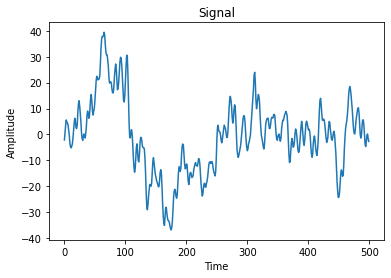

(2115, 22, 500, 1)


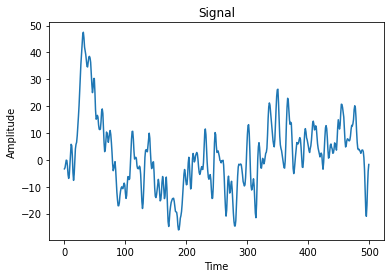

In [13]:
x_train = data_crop(X_train_valid)

x_train = data_augmentation(x_train)

# x_train = np.vstack((x_train, x_train_filter))

x_train = x_train.reshape(2115, 22, 500, 1)
y_train = to_categorical((y_train_valid - 769), 4)
y_train = np.vstack((y_train, y_train))

fig, axs = plt.subplots()
axs.set_title("Signal")
axs.plot(range(500), x_train[1,5,:,0], color='C0')
axs.set_xlabel("Time")
axs.set_ylabel("Amplitude")
print(y_train_valid[1]-769)

plt.show()

# generate a random permutation of indices
perm = np.random.permutation(len(x_train))

# shuffle the training data and labels using the permutation
x_train = x_train[perm]
y_train = y_train[perm]


fig, axs = plt.subplots()
axs.set_title("Signal")
axs.plot(range(500), x_train[1,5,:,0], color='C0')
axs.set_xlabel("Time")
axs.set_ylabel("Amplitude")
print(x_train.shape)

plt.show()

x_valid = x_train[2001:2114,:,:,:]
y_valid = y_train[2001:2114,:]

x_train = x_train[0:2000,:,:,:]
y_train = y_train[0:2000,:]


x_test = data_crop(X_test)
#x_test = data_augmentation(x_test)
x_test = x_test.reshape(443, 22, 500, 1)
y_test = to_categorical((y_test - 769), 4)

In [ ]:
class SquareLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        return tf.square(inputs)

    def get_config(self):
        return super().get_config()
    
class LogLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(LogLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.math.log(inputs)

In [ ]:
# Define an input layer for grayscale image
inputs = keras.Input(shape=(22,500,1), name="EEG")

x = keras.layers.Conv2D(filters=40, kernel_size=(1,25), activation=nn.elu, name='Temp-conv-side-1-2')(inputs)

x = tf.keras.layers.Permute((2,1,3), name = 'permute-0')(x)

x = tf.reshape(x,[-1,476,880])

x = tf.keras.layers.Dense(units=40)(x)

x = SquareLayer()(x)

x = tf.reshape(x,[-1,1,476,40])

x = keras.layers.AveragePooling2D(pool_size = (1, 75), strides = (1,15), name = 'Ave-Pool')(x)

x = LogLayer()(x)

x = keras.layers.Flatten()(x) 

class_probs = keras.layers.Dense(4, kernel_regularizer=L1L2(l1 = 0, l2 = 0), activation='softmax')(x) # Output FC layer with softmax activation

# now wrap the model inputs and outputs
model = keras.Model(inputs=inputs, outputs=class_probs, name="eeg_resnet")

model.compile(loss='categorical_crossentropy', optimizer= keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-8), metrics=[keras.metrics.categorical_accuracy])
    

# Printing the model summary
model.summary()

Model: "eeg_resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EEG (InputLayer)            [(None, 22, 500, 1)]      0         
                                                                 
 Temp-conv-side-1-2 (Conv2D)  (None, 22, 476, 40)      1040      
                                                                 
 permute-0 (Permute)         (None, 476, 22, 40)       0         
                                                                 
 tf.reshape (TFOpLambda)     (None, 476, 880)          0         
                                                                 
 dense (Dense)               (None, 476, 40)           35240     
                                                                 
 square_layer (SquareLayer)  (None, 476, 40)           0         
                                                                 
 tf.reshape_1 (TFOpLambda)   (None, 1, 476, 40)        0

In [ ]:
# Load the TensorBoard extension
%load_ext tensorboard
# we will use the datetime to label logs
import datetime
from keras.layers import Dense, Activation, Flatten,Dropout
from tensorflow.keras.optimizers import Adam

# create a tensorboard callback to visualize training
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

# anneals the learning rate
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 3, factor = 0.5)  # reduces by a factor of 10 if validation loss doesn't improve for 10 epochs

# Model parameters
lr =5e-4
epochs = 100
opt = Adam(learning_rate=lr)

# Compiling the model
model.compile(loss='categorical_crossentropy',
                 optimizer=opt,
                 metrics=['accuracy'])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='test_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Training and validating the model
hybrid_cnn_lstm_model_results = model.fit(x_train,
             y_train,
             batch_size=25,
             epochs=epochs,
             callbacks=[tb_callback, lr_callback],                    
             validation_data=(x_valid, y_valid), verbose=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/100
80/80 [==============================] - 3s 18ms/step - loss: 1.4656 - accuracy: 0.3330 - val_loss: 1.2883 - val_accuracy: 0.4690 - lr: 5.0000e-04
Epoch 2/100
80/80 [==============================] - 1s 11ms/step - loss: 1.2295 - accuracy: 0.4445 - val_loss: 1.1665 - val_accuracy: 0.4159 - lr: 5.0000e-04
Epoch 3/100
80/80 [==============================] - 1s 10ms/step - loss: 1.1091 - accuracy: 0.5215 - val_loss: 1.0970 - val_accuracy: 0.5664 - lr: 5.0000e-04
Epoch 4/100
80/80 [==============================] - 1s 9ms/step - loss: 1.0220 - accuracy: 0.5705 - val_loss: 1.0330 - val_accuracy: 0.5575 - lr: 5.0000e-04
Epoch 5/100
80/80 [==============================] - 1s 9ms/step - loss: 0.9507 - accuracy: 0.6190 - val_loss: 0.9799 - val_accuracy: 0.5664 - lr: 5.0000e-04
Epoch 6/100
80/80 [==============================] - 1s 11ms/step - loss: 0.8796 - accuracy: 0.6520 - val_loss: 0.960

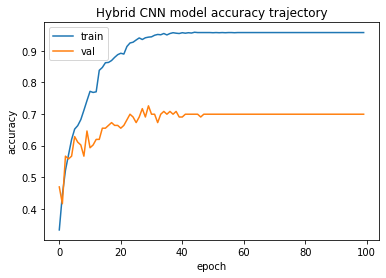

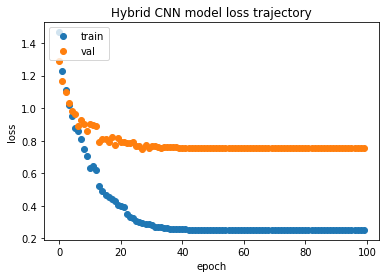

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the hybrid CNN-LSTM model
# load the saved model
loaded_model = tf.saved_model.load('/content/drive/MyDrive/Colab Notebooks/project_data/project/BestModel')

# make predictions with the loaded model
#y_pred = loaded_model.predict(x_test)
hybrid_cnn_lstm_score = loaded_model.evaluate(x_test,y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

loaded_model = tf.saved_model.load('C:\ECE C247\Final_project\project\BestModel')
hybrid_cnn_lstm_score = model.evaluate(x_test,y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

AttributeError: ignored

In [7]:
# Load the model architecture
with open('/content/drive/MyDrive/Colab Notebooks/project_data/project/BestModel/architecture.json', 'r') as f:
    model_architecture = f.read()

In [8]:
from tensorflow.keras.optimizers import legacy

# Old code
opt = keras.optimizers.Adam(learning_rate=5e-4)

# New code
opt = legacy.Adam(learning_rate=5e-4)

In [9]:
# Load the model architecture
with open('/content/drive/MyDrive/Colab Notebooks/project_data/project/BestModel/architecture.json', 'r') as f:
    model_architecture = f.read()

# Create a new model with the same architecture
loaded_model = tf.keras.models.model_from_json(model_architecture)

# Load the model weights
loaded_model.load_weights('/content/drive/MyDrive/Colab Notebooks/project_data/project/BestModel/weights')
#from tensorflow.keras.optimizers import Adam
#lr =5e-4
#opt = Adam(learning_rate=lr)
#opt = tf.keras.optimizers.legacy.Adam
# Compile the model
loaded_model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

hybrid_cnn_lstm_score = loaded_model.evaluate(x_test,y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.7065462470054626


14/14 [==============================] - 0s 6ms/step
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]
[1. 0. 2. 3. 3. 2. 2. 3. 3. 0. 2. 3. 2. 0. 1. 1. 3. 3. 2. 0. 2. 1. 0. 1.
 3. 2. 0. 1. 1. 3. 2. 2. 1. 1. 2. 0. 0. 0. 0. 3. 1. 2. 0. 1. 3. 2. 0. 3.
 2. 1. 1. 2. 0. 3. 3. 1. 1. 3. 3. 2. 1. 1. 3. 1. 0. 1. 1. 1. 2. 0. 0. 1.
 3. 2. 2. 0. 1. 2. 0. 2. 3. 2. 0. 1. 3. 0. 0. 3. 3. 0. 3. 2. 1. 1. 0. 2.
 0. 3. 1. 3. 1. 0. 0. 1. 2. 0. 0. 3. 2. 2. 3. 1. 3. 1. 0. 0. 1. 3. 1. 0.
 0. 0. 3. 2. 3. 0. 3. 0. 2. 3. 2. 1. 3. 1. 1. 3. 0. 1. 3. 0. 0. 2. 2. 0.
 2. 3. 3. 1. 0. 3. 0. 3. 1. 2. 1. 0. 2. 0. 1. 3. 0. 1. 2. 2. 1. 2. 3. 1.
 0. 3. 1. 1. 1. 3. 2. 0. 1. 2. 1. 3. 2. 3. 3. 1. 1. 3. 1. 2. 2. 1. 3. 2.
 3. 3. 2. 2. 1. 3. 2. 1. 3. 1. 0. 0. 3. 2. 0. 0. 0. 3. 3. 2. 0. 1. 0. 2.
 0. 0. 3. 2. 1. 1. 3. 1. 0. 2. 0. 1. 2. 3. 1. 1. 2. 0. 0. 1. 0. 3. 3. 3.
 2. 0. 0. 1. 1. 3. 0. 3. 0. 2. 3. 0. 1. 0. 0. 0. 3. 1. 2. 0. 1. 3. 0. 0.
 2. 3. 3. 2. 1. 0. 0. 3. 2. 2. 3. 1. 1. 3. 2. 0.

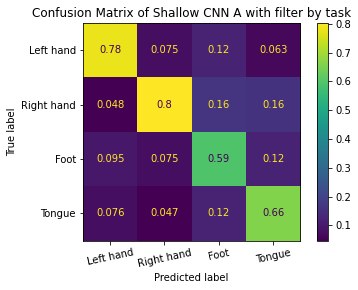

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_prediction = loaded_model.predict(x_test)
y_true=np.zeros(443)
y_pred=np.zeros(443)
display_labels = ['Left hand', 'Right hand','Foot','Tongue']
for ii in range(443):
  temp_label = -10
  temp_num = -10
  for jj in range(4):
    if y_test[ii,jj] > temp_num:
      temp_num = y_test[ii,jj]
      temp_label = jj
  y_true[ii] = temp_label
print(y_test)
print(y_true)
for ii in range(443):
  temp_label = -10
  temp_num = -10
  for jj in range(4):
    if y_prediction[ii,jj] > temp_num:
      temp_num = y_prediction[ii,jj]
      temp_label = jj
    y_pred[ii] = temp_label
print(y_prediction)
print(y_pred)
confusion = confusion_matrix(y_true, y_pred, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,display_labels=display_labels)
disp.plot()
disp.ax_.set_xticklabels(display_labels, rotation=12)
plt.title('Confusion Matrix of Shallow CNN A with filter by task')

plt.savefig('CNN_confusionmatrix.png')
plt.show()

[3 0 1 3 1 1 3 0 3 3 1 1 2 0 0 3 2 0 1 0 3 0 0 0 2 0 3 3 0 3 3 2 1 1 2 1 2
 1 3 0 0 2 2 1 1 0 3 2 3 1 2 3 3 2 0 0 0 3 3 0 0 3 0 3 0 2 3 2 0 0 1 0 2 2
 3 1 3 1 2 2 2 3 3 3 0 0 2 1 2 0 2 1 1 1 3 3 1 0 2 1]


<AxesSubplot:>

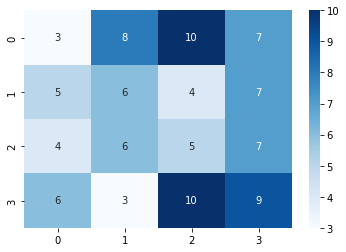

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Generate random labels for a 4-class classification problem
y_true = np.random.randint(low=0, high=4, size=100)
y_pred = np.random.randint(low=0, high=4, size=100)
print(y_true)
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])

Test accuracy of the hybrid CNN-LSTM model: 0.7110609412193298
14/14 [==============================] - 0s 7ms/step
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]
[1. 0. 2. 3. 3. 2. 2. 3. 3. 0. 2. 3. 2. 0. 1. 1. 3. 3. 2. 0. 2. 1. 0. 1.
 3. 2. 0. 1. 1. 3. 2. 2. 1. 1. 2. 0. 0. 0. 0. 3. 1. 2. 0. 1. 3. 2. 0. 3.
 2. 1. 1. 2. 0. 3. 3. 1. 1. 3. 3. 2. 1. 1. 3. 1. 0. 1. 1. 1. 2. 0. 0. 1.
 3. 2. 2. 0. 1. 2. 0. 2. 3. 2. 0. 1. 3. 0. 0. 3. 3. 0. 3. 2. 1. 1. 0. 2.
 0. 3. 1. 3. 1. 0. 0. 1. 2. 0. 0. 3. 2. 2. 3. 1. 3. 1. 0. 0. 1. 3. 1. 0.
 0. 0. 3. 2. 3. 0. 3. 0. 2. 3. 2. 1. 3. 1. 1. 3. 0. 1. 3. 0. 0. 2. 2. 0.
 2. 3. 3. 1. 0. 3. 0. 3. 1. 2. 1. 0. 2. 0. 1. 3. 0. 1. 2. 2. 1. 2. 3. 1.
 0. 3. 1. 1. 1. 3. 2. 0. 1. 2. 1. 3. 2. 3. 3. 1. 1. 3. 1. 2. 2. 1. 3. 2.
 3. 3. 2. 2. 1. 3. 2. 1. 3. 1. 0. 0. 3. 2. 0. 0. 0. 3. 3. 2. 0. 1. 0. 2.
 0. 0. 3. 2. 1. 1. 3. 1. 0. 2. 0. 1. 2. 3. 1. 1. 2. 0. 0. 1. 0. 3. 3. 3.
 2. 0. 0. 1. 1. 3. 0. 3. 0. 2. 3. 0. 1. 0. 0. 0. 3. 1. 2. 

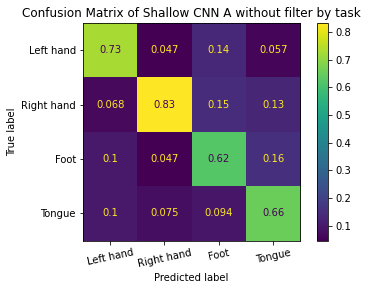

In [14]:
# Load the model architecture
with open('/content/drive/MyDrive/Colab Notebooks/project_data/project/BestModel_withoutfilter/architecture.json', 'r') as f:
    model_architecture = f.read()

# Create a new model with the same architecture
loaded_model = tf.keras.models.model_from_json(model_architecture)

# Load the model weights
loaded_model.load_weights('/content/drive/MyDrive/Colab Notebooks/project_data/project/BestModel_withoutfilter/weights')
#from tensorflow.keras.optimizers import Adam
#lr =5e-4
#opt = Adam(learning_rate=lr)
#opt = tf.keras.optimizers.legacy.Adam
# Compile the model
loaded_model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

hybrid_cnn_lstm_score = loaded_model.evaluate(x_test,y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_prediction = loaded_model.predict(x_test)
y_true=np.zeros(443)
y_pred=np.zeros(443)
display_labels = ['Left hand', 'Right hand','Foot','Tongue']
for ii in range(443):
  temp_label = -10
  temp_num = -10
  for jj in range(4):
    if y_test[ii,jj] > temp_num:
      temp_num = y_test[ii,jj]
      temp_label = jj
  y_true[ii] = temp_label
print(y_test)
print(y_true)
for ii in range(443):
  temp_label = -10
  temp_num = -10
  for jj in range(4):
    if y_prediction[ii,jj] > temp_num:
      temp_num = y_prediction[ii,jj]
      temp_label = jj
    y_pred[ii] = temp_label
print(y_prediction)
print(y_pred)
confusion = confusion_matrix(y_true, y_pred, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,display_labels=display_labels)
disp.plot()
disp.ax_.set_xticklabels(display_labels, rotation=12)
plt.title('Confusion Matrix of Shallow CNN A without filter by task')

plt.savefig('CNN_confusionmatrix.png')
plt.show()


In [ ]:
# Load the model architecture
with open('/content/drive/MyDrive/Colab Notebooks/project_data/project/BestModel_withoutfilter/architecture.json', 'r') as f:
    model_architecture = f.read()

# Create a new model with the same architecture
loaded_model = tf.keras.models.model_from_json(model_architecture)

# Load the model weights
loaded_model.load_weights('/content/drive/MyDrive/Colab Notebooks/project_data/project/BestModel_withoutfilter/weights')
#from tensorflow.keras.optimizers import Adam
#lr =5e-4
#opt = Adam(learning_rate=lr)
#opt = tf.keras.optimizers.legacy.Adam
# Compile the model
loaded_model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

hybrid_cnn_lstm_score = loaded_model.evaluate(x_test,y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.7110609412193298
